# Unit 2: Fisheries Collapse Module Overview

This module will focus on examining a crucial global issue and important scientific debate about the state of global fisheries.  In this module we will seek to reproduce some of the most widely cited examples of species collapse ever, and examine the evidence behind an influential and widely cited paper on global fisheries, [Worm et al 2006](http://doi.org/10.1126/science.1132294).  However, rather than use the limited data available to Boris Worm and colleagues in 2006, we will be drawing from the best and most recent stock asssement data available today to see how those patterns have faired.  

In this module we will also begin to master one of the most important concepts in data science: manipulation of tabular data using relational database concepts. Instead of working with independent data.frames, we will be working with a large relational database which contains many different tables of different sizes and shapes, but that all all related to each other through a series of different ids.  



## The Database

We will use data from the RAM Legacy Stock Assessment Database.  In order to better introduce some important emerging technologies, we will be accessing these data directly from a relatively new platform that is now playing a key role in data sharing in machine learning communities, with the memorable name, HuggingFace.  We will be streaming data from <https://huggingface.co/datasets/cboettig/ram_fisheries/tree/main/v4.65>.  We will have more to say about this approach as we progress.



## Researcher Spotlight: Daniel Pauly

Science is done by real people.  There are many influential and colorful characters in the global fisheries debate.  I want to highlight Professor Pauly not just because he is so famous, but as an early believer in Open Science and Data Science, before we had either of those words.  His contributions in making fisheries data more open were ground breaking for their time.  I'm also indebted to Professor Pauly whom I had the privilege to meet when I was a junior scientist who had only recently released one of my first software packages, aimed at making data from FishBase more accessible. Academic researchers are typically defined by scientific publications, not software, so I was shocked that Pauly already knew of my software package, and that he encouraged me to continue developing software.  Even today that is not common advice, but I believed him, and it's probably a good reason I am where I am today.  Scientific textbooks and courses are often critiqued for failing to recognize the contributions of those from minority backgrounds, but as the texts are written on global change ecology, I think none will omit the works for Professor Pauly.




## Science Introduction

Background abbreviated documentary, features many of the leading authors on both sides https://vimeo.com/44104959

In [19]:
# import required packages and backends
import ibis
from ibis import _
import ibis.selectors as s
import seaborn.objects as so
con=ibis.duckdb.connect() # Connect to duckDB to download the data



# Exercise 1: Investigating the North-Atlantic Cod

Now we are ready to dive into our data. First, We seek to replicate the following figure from the Millennium Ecosystem Assessment Project using the RAM data.

![](https://espm-157.github.io/website-r/img/cod.jpg)


In [3]:
# upload data using URLs
area_url = "https://huggingface.co/datasets/cboettig/ram_fisheries/resolve/main/v4.65/area.csv?download=true"
area = con.read_csv(area_url)

assessment_url = "https://huggingface.co/datasets/cboettig/ram_fisheries/resolve/main/v4.65/assessment.csv?download=true"
assessment = con.read_csv(assessment_url)

stock_url = "https://huggingface.co/datasets/cboettig/ram_fisheries/resolve/main/v4.65/stock.csv?download=true"
stock = con.read_csv(stock_url)

time_series_url = "https://huggingface.co/datasets/cboettig/ram_fisheries/resolve/main/v4.65/timeseries.csv?download=true"
time_series = con.read_csv(time_series_url,
    nullstr = "NA") # do not assume that columns containing NA are a string

metrics_url = "https://huggingface.co/datasets/cboettig/ram_fisheries/resolve/main/v4.65/tsmetrics.csv?download=true"
metrics = con.read_csv(metrics_url, nullstr = "NA") # do not assume that columns containing NA are a string

Let's reproduce the graph shown at the start of the notebook.

In [4]:
# check that we can filter down using the common name
stock.filter(_.commonname == "Atlantic cod").head().execute() # view the atlantic cod fish stock

,stockid,tsn,scientificname,commonname,areaid,stocklong,region,primary_country,primary_FAOarea,ISO3_code,GRSF_uuid,GRSF_areaid,inmyersdb,myersstockid,state
0,COD1ABCDE,164712,Gadus morhua,Atlantic cod,multinational-ICES-1ABCDE,Atlantic cod NAFO 1ABCDE,Canada East Coast,Greenland,21,GRL,01203eac-f124-34d5-80c0-44ce978b328e,fao:21.1.A;fao:21.1.B;fao:21.1.C;fao:21.1.D;fa...,0,NA,Current
1,COD1F-XIV,164712,Gadus morhua,Atlantic cod,multinational-ICES-1F-XIV,Atlantic cod NAFO 1F and ICES 14,Europe non EU,Greenland,27,GRL,269f6c1e-e0cd-3fcb-b2cc-41d338ac824e,fao:21.1.F;fao:27.14,0,NA,Current
2,COD1IN,164712,Gadus morhua,Atlantic cod,multinational-ICES-1IN,Atlantic cod NAFO Subarea 1 (inshore),Canada East Coast,Greenland,21,GRL,437d0699-5695-336d-b139-bc69de390334,fao:21.1,0,NA,Current
3,COD2J3KL,164712,Gadus morhua,Atlantic cod,Canada-DFO-2J3KL,Atlantic cod Southern Labrador-Eastern Newfoun...,Canada East Coast,Canada,21,CAN,c9055c35-a306-3a63-83b5-525d9f484840,fao:21.2.J;fao:21.3.K;fao:21.3.L,1,COD2J3KL,Current
4,COD3M,164712,Gadus morhua,Atlantic cod,multinational-NAFO-3M,Atlantic cod Flemish Cap,Canada East Coast,Portugal,21,PRT,ad76fd62-8f75-33d0-82cd-380f9c9f2533,fao:21.3.M,1,COD3M,Current


In [5]:
# explore possible metrics for plotting
metrics.filter(_.tscategory == "CATCH or LANDINGS").select(_.tslong, _.tsunique).distinct().execute()

,tslong,tsunique
0,Scientific advice for catch limit (pairs with ...,Cadvised-CMB-MT
1,Catch divided by model version only MSY,CdivMSY-mvo-ratio
2,Customary catch,CUSTC-MT
3,Recreational catch,RecC-MT
4,Total allowable catch,TAC-2-MT
...,...,...
63,Total catch. Use only when there is more than ...,TC-3-E06
64,Total catch (i.e. landings + discards. Add lan...,TC-E03
65,Total landings. Use only when there is more th...,TL-1-E03MT
66,Total landings in subarea,TL-A3-MT


In [6]:
# join tables together
fish = (time_series
    .rename(tsunique = "tsid")
    .join(metrics, "tsunique")
    .join(stock, ["stockid", "stocklong"]) # join on both columns
    .join(assessment, "assessid")
)
fish.head().execute()


,assessid,stockid,stocklong,tsunique,tsyear,tsvalue,tscategory,tsshort,tslong,tsunitsshort,...,assesssource,contacts,notes,pdffile,assess,refpoints,assessmethod,assesscomments,xlsfilename,mostrecent
0,ABARES-BGRDRSE-1960-2011-CHING,BGRDRSE,Blue grenadier Southeast Australia,CdivMEANC-ratio,1960,NaN,CATCH or LANDINGS,CdivMEANC,Catch divided by mean catch,ratio,...,http://adl.brs.gov.au/data/warehouse/9aam/fsrX...,NULL,NULL,00_FishStatus2011_1.0.0,1,1,SS3,NULL,/home/srdbadmin/srdb/spreadsheets/CHING-BGRDRS...,-1
1,ABARES-BGRDRSE-1960-2011-CHING,BGRDRSE,Blue grenadier Southeast Australia,CdivMEANC-ratio,1961,NaN,CATCH or LANDINGS,CdivMEANC,Catch divided by mean catch,ratio,...,http://adl.brs.gov.au/data/warehouse/9aam/fsrX...,NULL,NULL,00_FishStatus2011_1.0.0,1,1,SS3,NULL,/home/srdbadmin/srdb/spreadsheets/CHING-BGRDRS...,-1
2,ABARES-BGRDRSE-1960-2011-CHING,BGRDRSE,Blue grenadier Southeast Australia,CdivMEANC-ratio,1962,NaN,CATCH or LANDINGS,CdivMEANC,Catch divided by mean catch,ratio,...,http://adl.brs.gov.au/data/warehouse/9aam/fsrX...,NULL,NULL,00_FishStatus2011_1.0.0,1,1,SS3,NULL,/home/srdbadmin/srdb/spreadsheets/CHING-BGRDRS...,-1
3,ABARES-BGRDRSE-1960-2011-CHING,BGRDRSE,Blue grenadier Southeast Australia,CdivMEANC-ratio,1963,NaN,CATCH or LANDINGS,CdivMEANC,Catch divided by mean catch,ratio,...,http://adl.brs.gov.au/data/warehouse/9aam/fsrX...,NULL,NULL,00_FishStatus2011_1.0.0,1,1,SS3,NULL,/home/srdbadmin/srdb/spreadsheets/CHING-BGRDRS...,-1
4,ABARES-BGRDRSE-1960-2011-CHING,BGRDRSE,Blue grenadier Southeast Australia,CdivMEANC-ratio,1964,NaN,CATCH or LANDINGS,CdivMEANC,Catch divided by mean catch,ratio,...,http://adl.brs.gov.au/data/warehouse/9aam/fsrX...,NULL,NULL,00_FishStatus2011_1.0.0,1,1,SS3,NULL,/home/srdbadmin/srdb/spreadsheets/CHING-BGRDRS...,-1


In [28]:
# make a cod table that summarizes catches or landings
cod_catch = (fish
.filter(_.tscategory == 'CATCH or LANDINGS')
.filter(_.tsunique == 'TCbest-MT')
.filter(_.commonname == "Atlantic cod")
)

cod_catch.head().execute()


,assessid,stockid,stocklong,tsunique,tsyear,tsvalue,tscategory,tsshort,tslong,tsunitsshort,...,assesssource,contacts,notes,pdffile,assess,refpoints,assessmethod,assesscomments,xlsfilename,mostrecent
0,DFO-MAR-COD4VsW-1958-2002-PREFONTAINE,COD4VsW,Atlantic cod Eastern Scotian Shelf,TCbest-MT,1958,38600.0,CATCH or LANDINGS,TCbest,"General total Catch (TC then TL, MT units only)",MT,...,http://www.dfo-mpo.gc.ca/csas/csas/Publication...,"Robert Mohn, MohnR@dfo-mpo.gc.ca",The total mortality (Z) can be used as an esti...,NA,1,1,Unknown,no comments,../spreadsheets/PREFONTAINE-COD4VsW-2003-edite...,999
1,DFO-MAR-COD4VsW-1958-2002-PREFONTAINE,COD4VsW,Atlantic cod Eastern Scotian Shelf,TCbest-MT,1959,66000.0,CATCH or LANDINGS,TCbest,"General total Catch (TC then TL, MT units only)",MT,...,http://www.dfo-mpo.gc.ca/csas/csas/Publication...,"Robert Mohn, MohnR@dfo-mpo.gc.ca",The total mortality (Z) can be used as an esti...,NA,1,1,Unknown,no comments,../spreadsheets/PREFONTAINE-COD4VsW-2003-edite...,999
2,DFO-MAR-COD4VsW-1958-2002-PREFONTAINE,COD4VsW,Atlantic cod Eastern Scotian Shelf,TCbest-MT,1960,50600.0,CATCH or LANDINGS,TCbest,"General total Catch (TC then TL, MT units only)",MT,...,http://www.dfo-mpo.gc.ca/csas/csas/Publication...,"Robert Mohn, MohnR@dfo-mpo.gc.ca",The total mortality (Z) can be used as an esti...,NA,1,1,Unknown,no comments,../spreadsheets/PREFONTAINE-COD4VsW-2003-edite...,999
3,DFO-MAR-COD4VsW-1958-2002-PREFONTAINE,COD4VsW,Atlantic cod Eastern Scotian Shelf,TCbest-MT,1961,66300.0,CATCH or LANDINGS,TCbest,"General total Catch (TC then TL, MT units only)",MT,...,http://www.dfo-mpo.gc.ca/csas/csas/Publication...,"Robert Mohn, MohnR@dfo-mpo.gc.ca",The total mortality (Z) can be used as an esti...,NA,1,1,Unknown,no comments,../spreadsheets/PREFONTAINE-COD4VsW-2003-edite...,999
4,DFO-MAR-COD4VsW-1958-2002-PREFONTAINE,COD4VsW,Atlantic cod Eastern Scotian Shelf,TCbest-MT,1962,65200.0,CATCH or LANDINGS,TCbest,"General total Catch (TC then TL, MT units only)",MT,...,http://www.dfo-mpo.gc.ca/csas/csas/Publication...,"Robert Mohn, MohnR@dfo-mpo.gc.ca",The total mortality (Z) can be used as an esti...,NA,1,1,Unknown,no comments,../spreadsheets/PREFONTAINE-COD4VsW-2003-edite...,999


In [8]:

# filter to see how many stock ID columns there
cod_catch.group_by(_.stocklong).agg(n = _.count()).order_by(_.n.desc()).execute() # there are 28 unique stocks

#fish.columns # to view the columns
# we are probably most interested in TCbest-MT for plotting (metric ton unit)


,stocklong,n
0,Atlantic cod North-East Arctic,705
1,Atlantic cod ICES 3a(west)-4-7d,648
2,Atlantic cod Faroe Plateau,637
3,Atlantic cod Iceland Grounds,554
4,Atlantic cod Eastern Baltic,434
5,Atlantic cod Celtic Sea,391
6,Atlantic cod NAFO Subarea 1 (inshore),385
7,Atlantic cod West of Scotland,360
8,Atlantic cod Western Baltic,352
9,Atlantic cod Southern Labrador-Eastern Newfoun...,339


In [9]:
# which stock is likely the one in the figure?
old_cod = cod_catch.filter(_.tsyear == 1850)  # it has to go back at 1850
old_cod.execute() # there is only one

,assessid,stockid,stocklong,tsunique,tsyear,tsvalue,tscategory,tsshort,tslong,tsunitsshort,...,assesssource,contacts,notes,pdffile,assess,refpoints,assessmethod,assesscomments,xlsfilename,mostrecent
0,DFO-NFLD-COD2J3KL-1850-2011-CHING,COD2J3KL,Atlantic cod Southern Labrador-Eastern Newfoun...,TCbest-MT,1850,133000.0,CATCH or LANDINGS,TCbest,"General total Catch (TC then TL, MT units only)",MT,...,NULL,NULL,NULL,Stock Assesment of Northern (2J3KL) Cod in 2013,1,1,SURBA,NULL,/home/srdbadmin/srdb/spreadsheets/CHING-COD2J3...,0


In [10]:
# filter down to only the one stock using stockid
cod = (cod_catch
.filter(_.stockid== 'COD2J3KL')
)


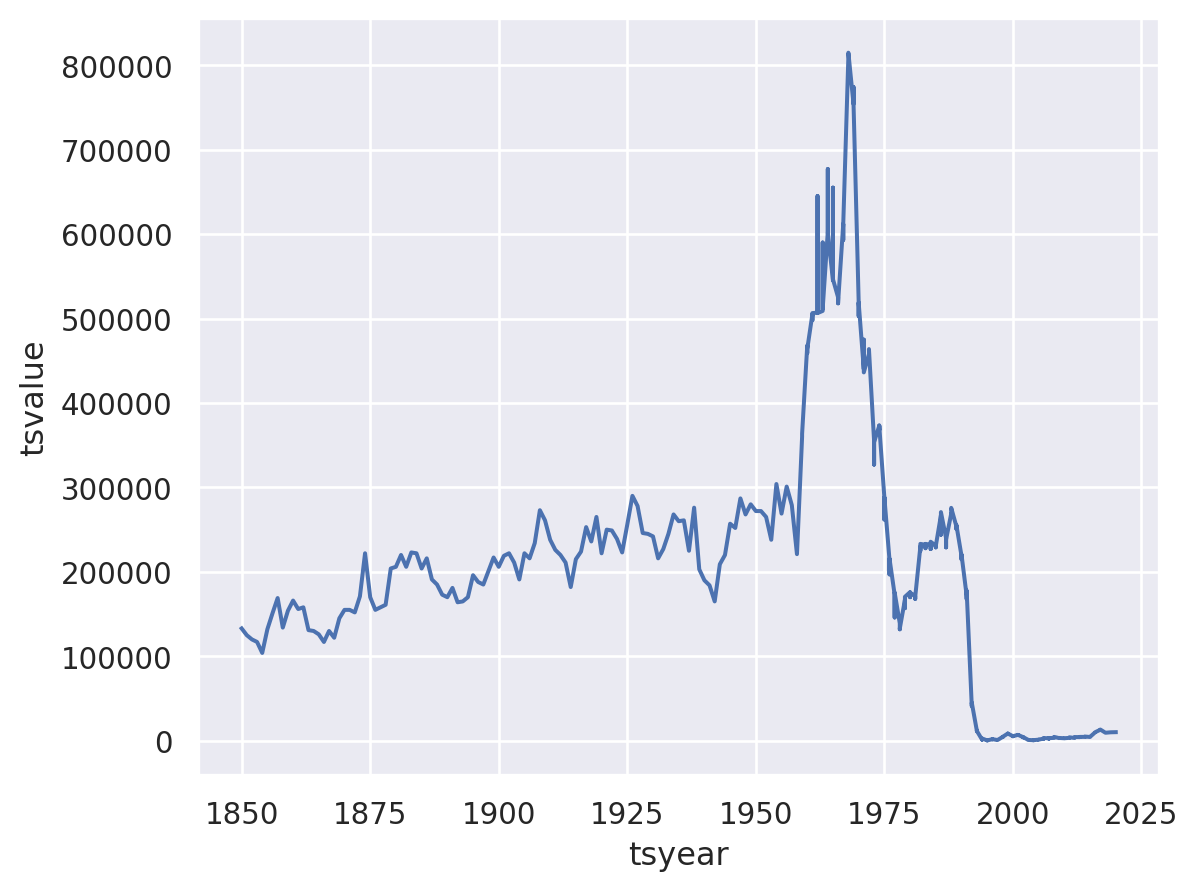

In [11]:
# plot the stock from the figure
so.Plot(cod, x = "tsyear", y = "tsvalue").add(so.Lines())

# Excersise 2: Global Fisheries

## Stock Collapses

We seek to replicate the temporal trend in stock declines shown in [Worm et al 2006](http://doi.org/10.1126/science.1132294):

![](https://espm-157.github.io/website-r/img/worm2006.jpg)



In [13]:
# take the peak
# when the stock hits 0 or > 10 % of the peak
# FORWARD in time
# then declare that it is "collapsed"

In [24]:
# Average stock per year
avg_year = (cod
.group_by(_.tsyear)
.aggregate(ts_sum=_.tsvalue.sum(),
year_count=_.tsyear.count())
.mutate(avg_ts_value = _.ts_sum/_.year_count)
)

avg_year.execute()

,tsyear,ts_sum,year_count,avg_ts_value
0,1855,132000.000000,1,132000.000000
1,1856,151000.000000,1,151000.000000
2,1858,134000.000000,1,134000.000000
3,1859,154000.000000,1,154000.000000
4,1864,130000.000000,1,130000.000000
...,...,...,...,...
166,2000,21649.518600,4,5412.379650
167,2010,8941.018438,4,2235.254609
168,2014,14230.011406,3,4743.337135
169,2015,9078.468019,2,4539.234009


In [25]:
# for one cod stock
crash = (avg_year
.order_by(_.tsyear)
.mutate(collapsed = _.avg_ts_value< 0.1 * _.avg_ts_value.cummax()) # ordered mutate
)

crash.head().execute()

,tsyear,ts_sum,year_count,avg_ts_value,collapsed
0,1850,133000.0,1,133000.0,False
1,1851,125000.0,1,125000.0,False
2,1852,120000.0,1,120000.0,False
3,1853,117000.0,1,117000.0,False
4,1854,104000.0,1,104000.0,False


In [26]:
# Checking which year had a collapse in the number of fish
collapse = crash.filter(_.collapsed == True)

collapse.execute()

,tsyear,ts_sum,year_count,avg_ts_value,collapsed
0,1992,172450.694000,4,43112.673500,True
1,1993,46787.348000,4,11696.837000,True
2,1994,8049.759200,4,2012.439800,True
3,1995,1646.289160,4,411.572290,True
4,1996,7535.180800,4,1883.795200,True
5,1997,3441.831400,4,860.457850,True
6,1998,18084.940000,4,4521.235000,True
7,1999,33941.566000,4,8485.391500,True
8,2000,21649.518600,4,5412.379650,True
9,2001,27745.662800,4,6936.415700,True


In [ ]:
# Average cod stocks for primary FAO areas i.e., area 21 and area 27
avg_year_new = (cod_catch
.group_by(_.tsyear, _.primary_FAOarea)
.aggregate(ts_sum=_.tsvalue.sum(),
year_count=_.tsyear.count())
.mutate(avg_ts_value = _.ts_sum/_.year_count)
)

avg_year_new.execute()

,tsyear,primary_FAOarea,ts_sum,year_count,avg_ts_value
0,1950,27,7.694473e+06,13,591882.538462
1,1953,27,7.313224e+06,14,522373.142857
2,1954,27,8.679589e+06,16,542474.312500
3,1958,27,1.284629e+07,24,535261.916667
4,1966,27,1.252253e+07,54,231898.651807
...,...,...,...,...,...
243,1927,21,3.132169e+05,4,78304.223250
244,1930,21,3.342228e+05,5,66844.562000
245,1941,21,2.617945e+05,5,52358.892600
246,1946,21,3.995204e+05,5,79904.082000


In [ ]:
# Determining if the stock in each area collapsed
crash_all = (avg_year_new
.order_by(_.tsyear)
.mutate(collapsed = _.avg_ts_value< 0.1 * _.avg_ts_value.cummax()) # ordered mutate
)

crash_all.execute()

,tsyear,primary_FAOarea,ts_sum,year_count,avg_ts_value,collapsed
0,1850,21,1.330000e+05,1,133000.000000,False
1,1851,21,1.250000e+05,1,125000.000000,False
2,1852,21,1.200000e+05,1,120000.000000,False
3,1853,21,1.170000e+05,1,117000.000000,False
4,1854,21,1.040000e+05,1,104000.000000,False
...,...,...,...,...,...,...
243,2019,27,1.937936e+06,25,77517.457634,False
244,2020,21,2.815027e+04,3,9383.423340,True
245,2020,27,1.056876e+06,13,81298.181661,False
246,2021,27,2.519843e+04,5,5039.686711,True


In [38]:
# Computing the percentage of collapsed stock in each year
collapsed_percentage = (
    crash_all
    .group_by(_.tsyear)
    .aggregate(
        total_stocks=_.count(),
        collapsed_stocks=_.collapsed.sum()
    )
    )
collapsed_percentage.execute()

,tsyear,total_stocks,collapsed_stocks
0,1850,1,0
1,1857,1,0
2,1860,1,0
3,1861,1,0
4,1866,1,0
...,...,...,...
168,2005,2,1
169,2013,2,1
170,2017,2,1
171,2019,2,1


In [39]:
#...continued computation of % of collapsed stock in each year in the selected FAO areas
percentage_collapsed = collapsed_percentage.mutate(
        collapsed_percentage=(collapsed_percentage.collapsed_stocks / collapsed_percentage.total_stocks) * 100)

percentage_collapsed.execute()

,tsyear,total_stocks,collapsed_stocks,collapsed_percentage
0,1850,1,0,0.0
1,1857,1,0,0.0
2,1860,1,0,0.0
3,1861,1,0,0.0
4,1866,1,0,0.0
...,...,...,...,...
168,2004,2,1,50.0
169,2006,2,1,50.0
170,2007,2,2,100.0
171,2008,2,2,100.0


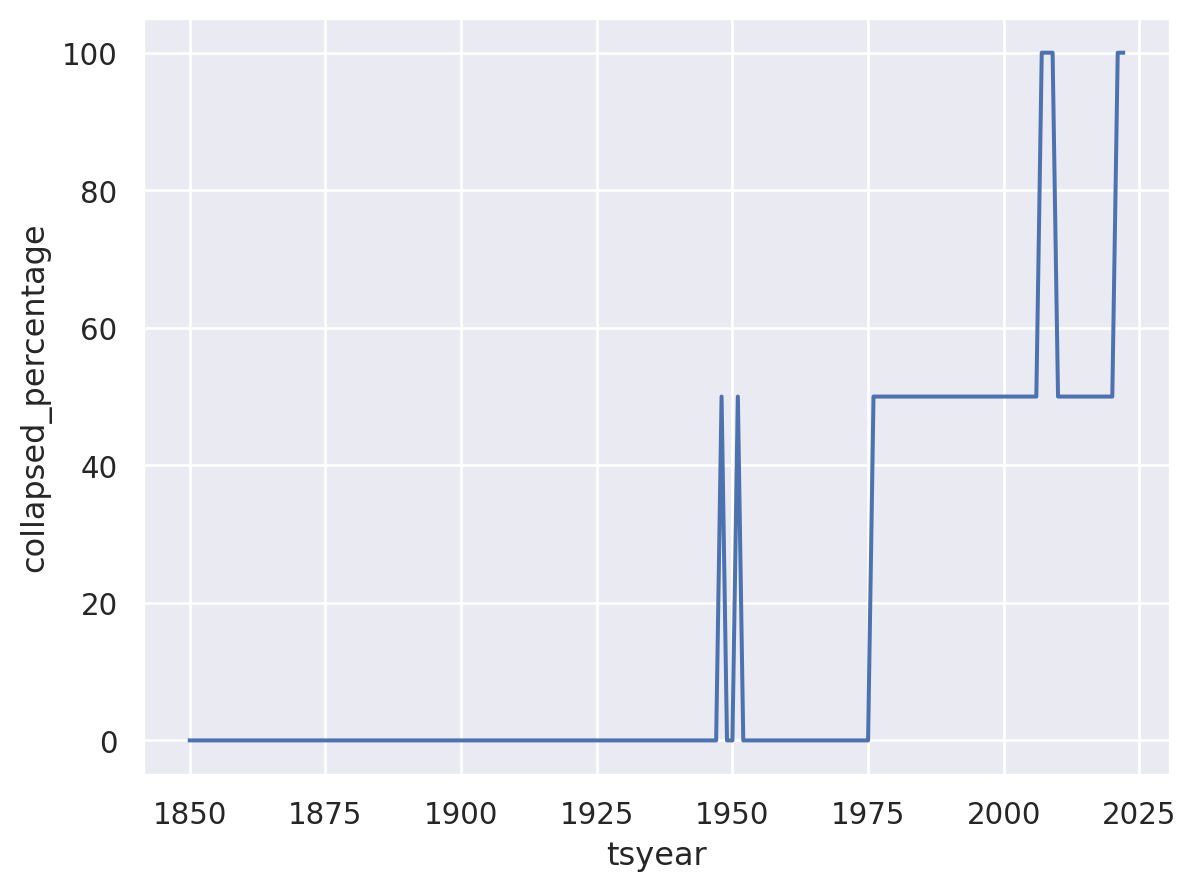

In [ ]:
# Plot of percentage of collapsed stock for each year in the primary FAO area
so.Plot(percentage_collapsed, x = "tsyear", y = "collapsed_percentage").add(so.Lines())

Next step is to calculate and plot the percentage of all collapsed fish species in all primary FAO area.